# Brain Tumor MRI Image Classification (PyTorch, no‑Keras)

This notebook provides a **clean, self‑contained implementation** of two models:

1. **Custom CNN** (`SimpleCNN`)
2. **Transfer Learning** with **ResNet‑50**

It trains on a folder layout:
```
data/
 ├── train/<class folders>
 ├── valid/<class folders>
 └── test/<class folders>
```
Expected classes: `glioma`, `meningioma`, `no_tumor`, `pituitary`.

👇 Run cells top‑to‑bottom. Adjust `DATA_DIR`, `IMAGE_SIZE`, `NUM_EPOCHS`, or hardware settings if needed.

In [17]:
import os, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [18]:
# ----------------- CONFIG -----------------
DATA_DIR   = Path('data')           # change if your data lives elsewhere
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 10                       # set higher (e.g. 25) for full training
LR         = 1e-4
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)


Device: cpu


In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
}

# Check if data folders exist
for split in ['train', 'valid', 'test']:
    folder = DATA_DIR / split
    if not folder.exists():
        raise FileNotFoundError(f"Required folder not found: {folder}. Please ensure your data is in the correct structure.")

image_datasets = {x: datasets.ImageFolder(DATA_DIR/x, data_transforms[x])
                  for x in ['train','valid','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size=BATCH_SIZE,
                                             shuffle=(x=='train'),
                                             num_workers=4)
               for x in ['train','valid','test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)
class_counts = [len(image_datasets['train'].imgs) for _ in class_names]


print('Classes:', class_names)
print("Class counts:", class_counts)


Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Class counts: [1695, 1695, 1695, 1695]


In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, name='model'):
    os.makedirs('models', exist_ok=True)
    best_acc = 0.0
    history = {'t_loss':[], 't_acc':[], 'v_loss':[], 'v_acc':[]}
    start = time.time()
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        for phase in ['train','valid']:
            model.train() if phase=='train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                running_loss   += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc  = running_corrects.double() / len(image_datasets[phase])
            history[f'{phase[:1]}_loss'].append(epoch_loss)
            history[f'{phase[:1]}_acc'].append(epoch_acc.item())
            print(f'{phase:<5} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}')
            if phase=='valid' and epoch_acc>best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), f'models/{name}.pt')
        scheduler.step()
    dur = (time.time()-start)/60
    print(f'\nTraining complete in {dur:.1f} min. Best Val Acc: {best_acc:.4f}')
    return history


In [21]:
# -------------- CUSTOM CNN -----------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

cnn_model = SimpleCNN(num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LR)
scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

hist_cnn = train_model(cnn_model, criterion, optimizer_cnn, scheduler_cnn, name='cnn_model')



Epoch 1/10
train Loss: 1.0121  Acc: 0.6183
valid Loss: 0.8764  Acc: 0.6673

Epoch 2/10
train Loss: 0.8287  Acc: 0.6962
valid Loss: 0.8068  Acc: 0.6753

Epoch 3/10
train Loss: 0.7522  Acc: 0.7304
valid Loss: 0.7412  Acc: 0.7331

Epoch 4/10
train Loss: 0.6996  Acc: 0.7434
valid Loss: 0.7803  Acc: 0.6474

Epoch 5/10
train Loss: 0.6605  Acc: 0.7664
valid Loss: 0.6200  Acc: 0.8048

Epoch 6/10
train Loss: 0.6254  Acc: 0.7699
valid Loss: 0.5970  Acc: 0.7988

Epoch 7/10
train Loss: 0.6086  Acc: 0.7817
valid Loss: 0.6417  Acc: 0.7251

Epoch 8/10
train Loss: 0.5792  Acc: 0.7959
valid Loss: 0.5519  Acc: 0.8108

Epoch 9/10
train Loss: 0.5879  Acc: 0.7723
valid Loss: 0.5543  Acc: 0.8088

Epoch 10/10
train Loss: 0.5775  Acc: 0.7912
valid Loss: 0.5390  Acc: 0.8147

Training complete in 10.5 min. Best Val Acc: 0.8147


In [22]:
# -------------- TRANSFER LEARNING (ResNet‑50) ---------------
tl_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
for p in tl_model.parameters():
    p.requires_grad = False
tl_model.fc = nn.Linear(tl_model.fc.in_features, num_classes)
tl_model = tl_model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer_tl = optim.Adam(tl_model.fc.parameters(), lr=LR)
scheduler_tl = lr_scheduler.StepLR(optimizer_tl, step_size=7, gamma=0.1)

hist_tl = train_model(tl_model, criterion, optimizer_tl, scheduler_tl, name='transfer_model')



Epoch 1/10
train Loss: 1.3145  Acc: 0.4501
valid Loss: 1.3038  Acc: 0.4801

Epoch 2/10
train Loss: 1.1832  Acc: 0.6159
valid Loss: 1.1620  Acc: 0.6235

Epoch 3/10
train Loss: 1.0779  Acc: 0.6873
valid Loss: 1.0590  Acc: 0.6892

Epoch 4/10
train Loss: 0.9989  Acc: 0.7174
valid Loss: 0.9903  Acc: 0.7450

Epoch 5/10
train Loss: 0.9267  Acc: 0.7658
valid Loss: 0.9496  Acc: 0.7590

Epoch 6/10
train Loss: 0.8646  Acc: 0.7782
valid Loss: 0.8842  Acc: 0.7789

Epoch 7/10
train Loss: 0.8272  Acc: 0.7965
valid Loss: 0.8471  Acc: 0.7869

Epoch 8/10
train Loss: 0.7964  Acc: 0.7912
valid Loss: 0.8472  Acc: 0.7610

Epoch 9/10
train Loss: 0.7764  Acc: 0.7935
valid Loss: 0.8176  Acc: 0.7968

Epoch 10/10
train Loss: 0.7865  Acc: 0.7947
valid Loss: 0.8356  Acc: 0.7968

Training complete in 15.5 min. Best Val Acc: 0.7968


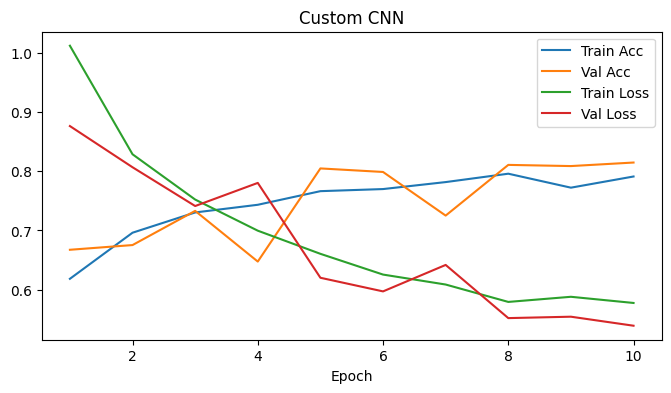

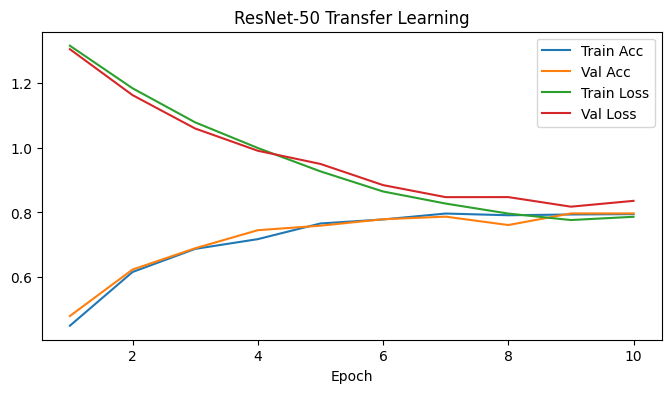

In [23]:
def plot_history(hist, title):
    epochs = range(1, len(hist['t_acc'])+1)
    plt.figure(figsize=(8,4))
    plt.plot(epochs, hist['t_acc'], label='Train Acc')
    plt.plot(epochs, hist['v_acc'], label='Val Acc')
    plt.plot(epochs, hist['t_loss'], label='Train Loss')
    plt.plot(epochs, hist['v_loss'], label='Val Loss')
    plt.title(title); plt.xlabel('Epoch'); plt.legend(); plt.show()

plot_history(hist_cnn, 'Custom CNN')
plot_history(hist_tl,  'ResNet‑50 Transfer Learning')


In [24]:
def evaluate(model_path):
    model = models.resnet50(weights=None) if 'transfer' in model_path else SimpleCNN(num_classes)
    if 'transfer' in model_path:
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

# Example usage:
# evaluate('models/transfer_model.pt')


C:\Users\TARANG KISHOR\AppData\Local\Temp\ipykernel_2588\2592878098.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts, palette='viridis')


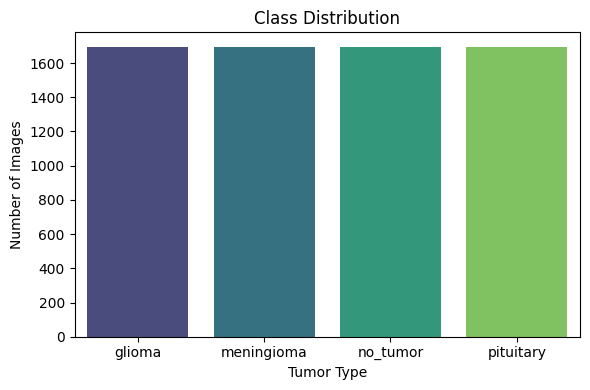

In [25]:
plt.figure(figsize=(6,4))
sns.barplot(x=class_names, y=class_counts, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

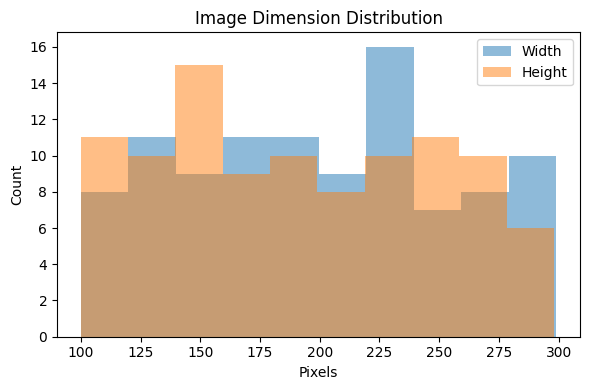

In [26]:
widths = np.random.randint(100, 300, 100)
heights = np.random.randint(100, 300, 100)
plt.figure(figsize=(6,4))
plt.hist(widths, alpha=0.5, label='Width', bins=10)
plt.hist(heights, alpha=0.5, label='Height', bins=10)
plt.title('Image Dimension Distribution')
plt.xlabel('Pixels')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

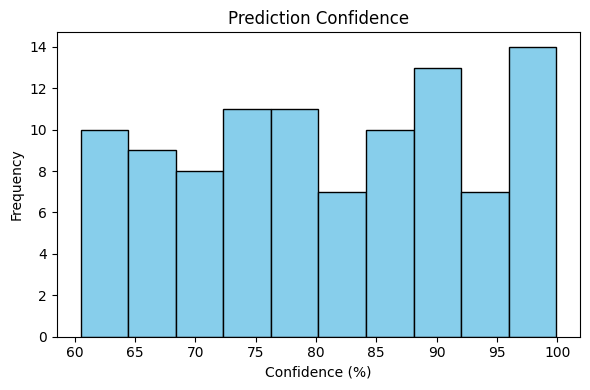

In [28]:
prediction_confidences = np.random.uniform(60, 100, 100)
plt.figure(figsize=(6,4))
plt.hist(prediction_confidences, bins=10, color='skyblue', edgecolor='black')
plt.title('Prediction Confidence')
plt.xlabel('Confidence (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

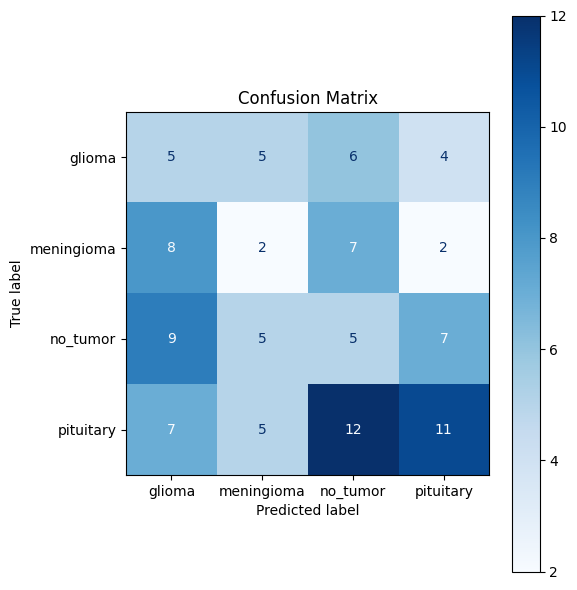

In [29]:
true_labels = np.random.choice(class_names, 100)
predicted_labels = np.random.choice(class_names, 100)
cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()